##### Objective: Make NFL Playcall Predictions
* Will the team on offense choose a rushing or passing play?
* Will the team convert a 1st down?
* Will the team punt, FG, go for it on 4th down?
* Percentage predictions for e.g. Sack, Interception, Touchdown, Safety

##### Needed data cleaning
* convert mis-categorized clockstops with defender named "Spikes"
* Pull in other dataset for offensive coordinators and coaches
* Make sure no null RushDirection on any PlayType == RUSH
* Make sure no null PassType on any PlayType == RUSH

##### Add columns
* Time remaining in game
* Time remaining in half
* Coach
* Offensive coordinator
* Formation (parse from description)
* Prev PlayType

In [26]:
import pandas as pd
from itertools import count

CSV_NAME = 'data/NFLPlaybyPlay2015.csv'

DROP_PLAYTYPES = {
    'No Play',
    'Kickoff',
    'Timeout',
    'Quarter End',
    'Two Minute Warning',
    'End of Game',
    'Onside Kick',
    'Half End',
    'Extra Point',
    'QB Kneel',
    'Spike',
}

DROP_COLUMNS = [
    'Unnamed: 0',
    'Returner',
    'BlockingPlayer',
    'Tackler1',
    'Tackler2',
    'PlayTimeDiff',
    'Challenge.Replay',
    'ChalReplayResult',
    'Accepted.Penalty',
    'PenalizedTeam',
    'PenaltyType',
    'PenalizedPlayer',
    'Penalty.Yards',
    'Season',
    'Interceptor',
    'Date',
    'ExPointResult',
    'Receiver',
    'ReturnResult',
    'Fumble',
    'RecFumbTeam',
    'RecFumbPlayer',
    'GoalToGo',
    'Drive',
    'TwoPointConv',
    'DefTwoPoint',
    'FieldGoalResult',
    'FieldGoalDistance',
    'PuntResult',
]

COL_RENAME_MAP = {
    'sp': 'ScoringPlay',
    'desc': 'Description',
    'qtr': 'Quarter',
    'down': 'Down',
    'time': 'Time',
    'posteam': 'OffensiveTeam',
    'DefTeamScore': 'DefensiveTeamScore',
    'PosTeamScore': 'OffensiveTeamScore',
    'Yards.Gained': 'YardsGained',
    'yrdln': 'YardLine',
    'yrdline100': 'YardLineOf100',
    'ydstogo': 'YardsToGo',
    'ydsnet': 'YardsNet',
}

DROPNA_COLS = [
    'ScoreDiff',
    'Time',
    'Down',
    'FirstDown',
]

FEATURE_COLS = [
    'Down',
    'TimeSecs',
    'YardsToGo',
    'ScoreDiff',
#     'OffensiveTeam',
#     'DefensiveTeam',
    # Add "Coach" column
    # Add "Offensive Coordinator" column
#     'Passer',
]

RESPONSE_COL = 'PlayTypeInt'

In [37]:

def clean_nfl_plays_dataframe(unclean_df):
    """Clean dataframe in a number of ways."""
    df = unclean_df.copy()

    # Drop irrelevant columns
    df.drop(DROP_COLUMNS, axis=1, inplace=True)
    
    # Rename poorly named columns
    df.rename(columns=COL_RENAME_MAP, inplace=True)

    # Drop any remaining rows with null values in specific columns (weird data)
    df.dropna(subset=DROPNA_COLS, inplace=True)

    # Drop plays with irrelevant playtypes
    df.drop(df[df.PlayType.isin(DROP_PLAYTYPES)].index, inplace=True)
    
    # Change SACK PlayType to PASS -- assuming sack was made during pass attempt
    df.PlayType.replace('Sack', 'Pass', inplace=True)
    
    return df


In [28]:
uncleaned_plays = pd.read_csv(CSV_NAME, header=0)

In [29]:
plays = clean_nfl_plays_dataframe(uncleaned_plays)

In [30]:
plays.PlayType.value_counts()

Pass          19447
Run           13067
Punt           2443
Field Goal      988
Name: PlayType, dtype: int64

In [31]:
plays.columns

Index([u'GameID', u'Quarter', u'Down', u'Time', u'TimeUnder', u'TimeSecs',
       u'SideofField', u'YardLine', u'YardLineOf100', u'YardsToGo',
       u'YardsNet', u'FirstDown', u'OffensiveTeam', u'DefensiveTeam',
       u'Description', u'PlayAttempted', u'YardsGained', u'ScoringPlay',
       u'Touchdown', u'Safety', u'PlayType', u'Passer', u'PassAttempt',
       u'PassOutcome', u'PassLength', u'PassLocation', u'InterceptionThrown',
       u'Rusher', u'RushAttempt', u'RunLocation', u'RunGap', u'Reception',
       u'Sack', u'OffensiveTeamScore', u'DefensiveTeamScore', u'ScoreDiff',
       u'AbsScoreDiff'],
      dtype='object')

In [32]:
plays.shape

(35945, 37)

In [33]:
playtype_int_map = dict(zip(plays.PlayType.unique(), count()))

plays[RESPONSE_COL] = plays.PlayType.map(playtype_int_map)

### Training and testing

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

K_RANGE = range(1, 20)
features = plays[FEATURE_COLS]
response = plays[RESPONSE_COL]

In [38]:


training_error = []
testing_error = []


for n in K_RANGE:
    features_train, features_test, response_train, response_test = train_test_split(features, response)
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(features, response)
    prediction = knn.predict(features)
    training_accuracy = accuracy_score(response, prediction)
    training_error.append(1 - training_accuracy)
    
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(features_train, response_train)
    prediction = knn.predict(features_test)
    testing_accuracy = accuracy_score(response_test, prediction)
    testing_error.append(1 - testing_accuracy)


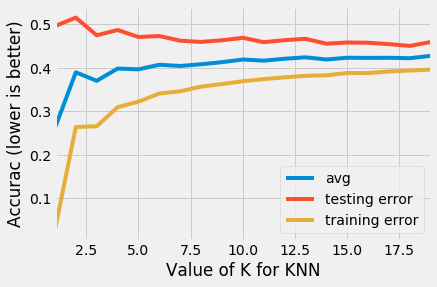

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
column_dict = {
    'K': K_RANGE,
    'training error': training_error,
    'testing error': testing_error,
    'avg': [(tr + te)/2.0 for tr, te in zip(training_error, testing_error)]
}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=True)
df.plot()
plt.xlabel('Value of K for KNN')
plt.ylabel('Accurac (lower is better)')

In [41]:
plays.PlayType.value_counts(1)

Pass          0.541021
Run           0.363528
Punt          0.067965
Field Goal    0.027486
Name: PlayType, dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

for n in K_RANGE:
    features_train, features_test, response_train, response_test = train_test_split(features, response)
    knn = RandomForestClassifier(n_neighbors=n)
    knn.fit(features, response)
    prediction = knn.predict(features)
    training_accuracy = accuracy_score(response, prediction)
    training_error.append(1 - training_accuracy)
    
    knn = RandomForestClassifier(n_neighbors=n)
    knn.fit(features_train, response_train)
    prediction = knn.predict(features_test)
    testing_accuracy = accuracy_score(response_test, prediction)
    testing_error.append(1 - testing_accuracy)